# Introduction to TensorFlow

by [Fabio A. González](http://dis.unal.edu.co/~fgonza/), Universidad Nacional de Colombia


version 2.0, June 2019

 [Machine Learning 2019-1](https://fagonzalezo.github.io/ml-2019-1/)


This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). 


In [0]:
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline


# Helper functions to inline visualization of computing graphs
# Extracted from: 
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

### 1. TensorFlow basics

First we will create a simple computing graph and visualize it. The visualization is interactive, so you can expand and collapse nodes, zoom in, zoom out, pan, etc.

In [0]:
graph = tf.Graph()

with graph.as_default():
    a = tf.constant(10, tf.float32, name= 'a')
    b = tf.constant(-5, tf.float32, name= 'b')
    c = tf.constant(4, tf.float32, name= 'c')

    x = tf.placeholder(tf.float32, name= 'x')
    new_exp = x + c
    y = a * x * x + b * x + c
    
show_graph(graph.as_graph_def())

If we try to evaluate `y` it produces an object, not a value:

In [0]:
y

<tf.Tensor 'add_2:0' shape=<unknown> dtype=float32>

To evaluate the expression we have to give a value to create a session and run the graph giving a value to `x`:

In [0]:
with graph.as_default():
    sess = tf.Session()
    result = sess.run(new_exp, {x: 5.0})
    sess.close()

print('y =', result)

y = 9.0


We can calculate the gradient of `y` with respect to a variable (or placeholder) in the graph:

In [0]:
with graph.as_default():
    y_prime = tf.gradients(y, [x])
    
    sess = tf.Session()
    result = sess.run([y,y_prime], {x: 5.0})
    sess.close()

In [0]:
print(result)

[229.0, [95.0]]


This expands the graph with the gradient calculation component:

In [0]:
show_graph(graph.as_graph_def())

We can use gradient descent to find a minimum of the polynomial represented in the graph. Here we need to change `x` to be a variable because its value is going to be updated for different sucessive evaluations of the graph.

In [0]:
graph = tf.Graph()
with graph.as_default():
    a = tf.constant(10, tf.float32, name= 'a')
    b = tf.constant(-5, tf.float32, name= 'b')
    c = tf.constant(4, tf.float32, name= 'c')
    x = tf.Variable(10.0, name= 'x')
    y = a * x * x + b * x + c

    optimizer = tf.train.GradientDescentOptimizer(0.02)
    update = optimizer.minimize(y)

    # Graph execution
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for i in range(20):
        val_y, val_x, _ = sess.run([y, x, update])
        print(i, val_x, val_y)
    sess.close()

0 6.1 954.0
1 3.76 202.86
2 2.3560002 73.7856
3 1.5136001 27.880419
4 1.0081601 11.691512
5 0.7048961 9.123068
6 0.52293766 5.4443045
7 0.4137626 4.1199493
8 0.34825754 3.6431818
9 0.30895454 3.4715455
10 0.28537273 3.4097564
11 0.27122363 3.3875122
12 0.26273417 3.3795044
13 0.2576405 3.3766217
14 0.2545843 3.3755836
15 0.25275058 3.3752103
16 0.25165033 3.3750756
17 0.2509902 3.3750272
18 0.25059414 3.3750098
19 0.2503565 3.3750036


Again the graph is expanded to contain the gradient calculations and the update rules of the optimizer. You can see two new containers `gradients` and `GradientDescent` which can be expanded. 

In [0]:
show_graph(graph.as_graph_def())

### 2. Neural network training 

Now we will implement a logistic regression model to classify the following data:

W0614 04:18:41.749760 140102836737920 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0614 04:18:41.761526 140102836737920 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


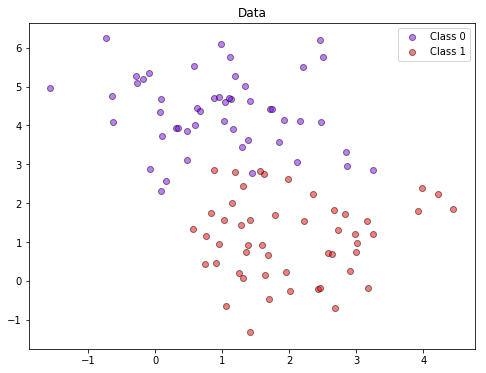

In [0]:
X, Y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=0)
pl.figure(figsize=(8, 6))
plot_data(X, Y)

The following graph implements a logistic regression model. Scopes help to organize the graph 
in submodules. `x` and `y_true` are the main inputs to the model. `None` in the shape indicates
that they can fit inputs with different number of samples, so we can present the whole training dataset
or minibatches. The `inference` module corresponds to the prediction part of the module. Notice that `y_pred` is just the lineal combination, it does not apply the logistic function. This is done directly in the loss function. The `loss` module specify the loss function to use, in this case, `sigmoid_cross_entropy_with_logits` the *logits* correspond to the linear combination in `y_pred`. The reduce `tf.reduce_mean` function calculates a mean loss for all the samples that were presented at once. The `train` module includes a gradien descent optimizer.

In [0]:
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32,shape=[None,2])
    y_true = tf.placeholder(tf.float32,shape=None)
    
    with tf.name_scope('inference') as scope:
        w = tf.Variable([[0,0]],dtype=tf.float32,name='weights')
        b = tf.Variable(0,dtype=tf.float32,name='bias')
        y_pred = tf.matmul(w,tf.transpose(x)) + b

    with tf.name_scope('loss') as scope:
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
        loss = tf.reduce_mean(loss)
  
    with tf.name_scope('train') as scope:
        learning_rate = 1.0
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

show_graph(graph.as_graph_def())

The optimization algorithm is run for `num_epochs` iterations or epochs. In each epoch the whole training dataset is presented.
Each five iterations, we run the model to calculate the loss, which is stored and later plotted. Notice that the session is not closed since we will need the values of the variables to predict additional samples.

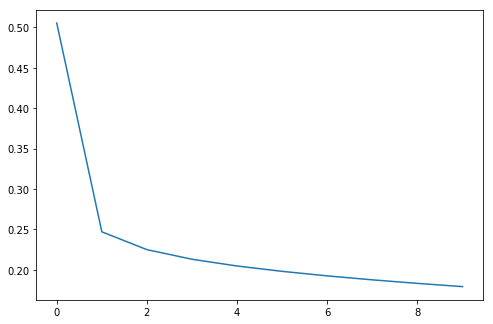

In [0]:
num_epochs = 50
losses = []

with graph.as_default():
    sess = tf.Session()
    sess.run(init)      
    for step in range(num_epochs):
        sess.run(train,{x: X, y_true: Y})
        if (step % 5 == 0):
            losses.append(sess.run(loss, {x: X, y_true: Y}))
                       
pl.figure(figsize = (8,16/3))
pl.plot(losses)

Now we use the `plot_decision_function`, defined at the beginning of the handout, to visualize the decision region.  Notice the that the graph is run as many times as different values the visualization grid has, this is very inefficient! The efficient way to do it is passing all the values at the same time to the graph. However, for this example the inefficient method works just fine.

[[ 1.3167489 -1.5882863]]
[[0.07089913]]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


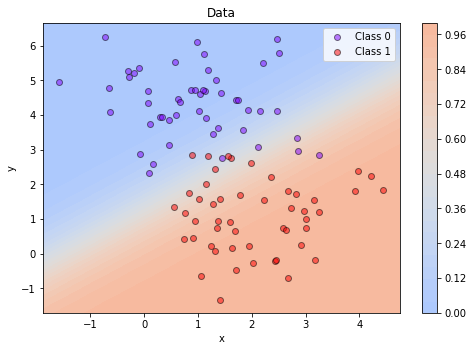

In [0]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

with graph.as_default():
    wval = sess.run(w)
    print(wval)
    result = sess.run(y_pred, {x:np.array([[1,2]])})
    print(result)
    def pred_fun(x1, x2):
        xval = np.array([[x1, x2]])
        return sigmoid(sess.run(y_pred,{x: xval}))

pl.figure(figsize = (8,16/3))    
plot_decision_region(X, pred_fun)
plot_data(X, Y)

Clossing the session.

In [0]:
 sess.close()

### 3. Using TensorBoard

TensorBoard is an application provided by TensorFlow that allows to monitor the training process. TensorBoard uses as input log files which are created by a summary mechanism. Summaries correspond to operators in the graph that calculate statistics of other graph variables.

The following function calculates different summary statistics for a given variable:

In [0]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

We define a new graph that includes these summaries:

In [0]:
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32,shape=[None,2])
    y_true = tf.placeholder(tf.float32,shape=None)
    
    with tf.name_scope('inference') as scope:
        w = tf.Variable([[0,0]],dtype=tf.float32,name='weights')
        b = tf.Variable(0,dtype=tf.float32,name='bias')
        y_pred = tf.matmul(w,tf.transpose(x)) + b
        variable_summaries(w)
        variable_summaries(b)

    with tf.name_scope('loss') as scope:
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
        loss = tf.reduce_mean(loss)
        variable_summaries(loss)
  
    with tf.name_scope('train') as scope:
        learning_rate = 1.0
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train = optimizer.minimize(loss)

    merged = tf.summary.merge_all()
    init = tf.global_variables_initializer()

show_graph(graph.as_graph_def())

We will split the dataset in train and test, so that we
can compute both the training and validation loss.
We create a `train_writer` and a `test_writer` that that work as handles to write the respective logs. 

In [0]:
x_train = X[:50]
x_test  = X[50:]
y_train = Y[:50]
y_test  = Y[50:]

LOG_DIR = 'logs'
train_writer = tf.summary.FileWriter(LOG_DIR + '/train',
                                 graph=graph)
test_writer = tf.summary.FileWriter(LOG_DIR + '/test')

num_epochs = 400

with graph.as_default():
    with tf.Session() as sess:
        sess.run(init)      
        for step in range(num_epochs):
            summary, train_loss, _ = sess.run([merged, loss, train] ,{x: x_train, y_true: y_train})
            train_writer.add_summary(summary, step)
            summary, val_loss = sess.run([merged, loss] ,{x: x_test, y_true: y_test})
            test_writer.add_summary(summary, step)
            if step % 20 == 0:
                print(step, train_loss, val_loss)
                

0 0.6931472 0.43206218
20 0.16180742 0.27600694
40 0.14276874 0.27437234
60 0.13373154 0.27041864
80 0.12786475 0.26509127
100 0.123512484 0.25918666
120 0.12005596 0.25315437
140 0.117202155 0.2472453
160 0.11478847 0.24159808
180 0.11271367 0.23628534
200 0.11090906 0.23133859
220 0.1093251 0.22676498
240 0.10792432 0.22255592
260 0.10667751 0.218694
280 0.10556146 0.21515651
300 0.10455723 0.21191849
320 0.10364933 0.20895456
340 0.10282492 0.2062397
360 0.1020733 0.20375046
380 0.101385444 0.20146465


Finally, we can launch TensorBoard from the console wiht the 
following command:

`tensorboard --logdir=logs/`

After launching it, we need to visit: http://localhost:6006 or whatever address TensroBoard tells us.

Also, you can run TensorBoard inside a Colab notebook. [Here](https://disq.us/url?url=https%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F1afN2SALDooZIHbBGmWZMT6cZ8ccVElWk%2Fview%3Fusp%3Dsharing%3AgG6fdOo47y45yn15Sfh2QTdWps4&cuid=5350564) you can check a notebook with the instructions.

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-06-14 04:43:12--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.21.103.149, 34.206.130.40, 54.164.181.42, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.21.103.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16648024 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  15.88M  19.1MB/s    in 0.8s    

2019-06-14 04:43:18 (19.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [16648024/16648024]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://155a09b1.ngrok.io
